In [5]:
import os

key = os.getenv("OPENAI_API_KEY")
print("OPENAI_API_KEY is set:", bool(key))
print("Length:", len(key) if key else None)
print("Prefix:", key[:7] + "..." if key else None)  # optional: shows only first chars


OPENAI_API_KEY is set: True
Length: 164
Prefix: sk-proj...


In [6]:
from mlflow.genai import make_judge  # preferred in newer MLflow :contentReference[oaicite:2]{index=2}

gt_judge = make_judge(
    name="xr_config_quality_score",
    instructions=(
        "You are grading an IOS XR telemetry configuration.\n\n"
        "User request (inputs): {{ inputs }}\n\n"
        "Candidate config (outputs): {{ outputs }}\n\n"
        "Reference acceptable config (expectations): {{ expectations }}\n\n"
        "Score quality from 0.0 to 1.0.\n"
        "Hard requirements (must match): IP, port, transport (grpc no-tls), encoding.\n"
        "Be lenient about names, ordering, and sample-interval unless requested.\n"
        "Penalize only if sensor-paths are clearly unrelated.\n"
        "Do NOT output telemetry config. Do NOT output code. Keep any explanation extremely short."
    ),
    feedback_value_type=float,
    model="openai:/gpt-4.1-mini",
    inference_params={"temperature": 0, "max_tokens": 300},  # <-- was 10 (too small)
)


In [7]:
from dataclasses import dataclass
from typing import Any, Dict

@dataclass(frozen=True)
class RunCfg:
    vector_db: str
    top_k: int
    filter_fields: Dict[str, Any]
    temperature: float
    model_chat: str
    model_embed: str


In [8]:
def make_grid(vector_dbs, top_ks, filters, temps, chat_models, embed_models):
    cfgs = []
    for vdb in vector_dbs:
        for k in top_ks:
            for ff in filters:
                for t in temps:
                    for cm in chat_models:
                        for em in embed_models:
                            cfgs.append(RunCfg(vdb, k, ff, t, cm, em))
    return cfgs

VECTOR_DBS = ["fixed_window_embeddings", "catalog_embeddings_improved"]  # add your 3rd
TOP_KS = [5, 10]
FILTERS = [{}]  # adjust to your payload schema,  {"protocol_tag": "bgp"}
TEMPS = [0,0.1]
CHAT_MODELS = ["gpt-4.1-nano", "gpt-4.1-mini"]
EMBED_MODELS = ["text-embedding-3-small"]

cfgs = make_grid(VECTOR_DBS, TOP_KS, FILTERS, TEMPS, CHAT_MODELS, EMBED_MODELS)
len(cfgs), cfgs[0]


(16,
 RunCfg(vector_db='fixed_window_embeddings', top_k=5, filter_fields={}, temperature=0, model_chat='gpt-4.1-nano', model_embed='text-embedding-3-small'))

In [9]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve().parents[0]  # repo root if cwd==repo/notebooks
sys.path.insert(0, str(ROOT / "src"))

In [10]:
from tracerag.rag.naive import naive_rag, build_openai_chat_fn
from tracerag.retrieval.qdrant import (
    QdrantRetrievalConfig,
    build_openai_embedding_fn,
    build_qdrant_retriever,
)

print("Imported tracerag modules OK.")


Imported tracerag modules OK.


In [11]:
@dataclass(frozen=True)
class RunCfg:
    vector_db: str                 # we'll map this to a Qdrant collection (or backend)
    top_k: int
    filter_fields: Dict[str, Any]  # e.g., {"domain":"bgp"} or {}
    temperature: float
    model_chat: str
    model_embed: str


In [12]:

from openai import OpenAI
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels

from typing import Any, Dict, List, Optional, Sequence, Tuple


In [13]:
def build_qdrant_filter(filter_fields: Dict[str, Any]) -> Optional[qmodels.Filter]:
    if not filter_fields:
        return None

    must: List[qmodels.FieldCondition] = []
    for key, value in filter_fields.items():
        must.append(
            qmodels.FieldCondition(
                key=key,
                match=qmodels.MatchValue(value=value),
            )
        )
    return qmodels.Filter(must=must)


In [14]:
def make_retriever(
    *,
    cfg: RunCfg,
    qdrant: QdrantClient,
    openai_client: OpenAI,
):
    embed_fn = build_openai_embedding_fn(openai_client, model=cfg.model_embed)

    q_filter = build_qdrant_filter(cfg.filter_fields)

    config = QdrantRetrievalConfig(
        collection_name=cfg.vector_db,  # <-- mapping: vector_db -> collection
        top_k=cfg.top_k,
        query_filter=q_filter,
    )

    qdrant_retriever = build_qdrant_retriever(
        qdrant=qdrant,
        embedding_fn=embed_fn,
        config=config,
    )

    # Return a function: retriever(query, k) -> List[Chunk]
    # Keep filter fixed per cfg (since filter_fields is a variation)
    return lambda query, k: qdrant_retriever(query, top_k=k, query_filter=q_filter)


def make_chat_fn(cfg: RunCfg, openai_client: OpenAI):
    return build_openai_chat_fn(
        openai_client,
        model=cfg.model_chat,
        temperature=cfg.temperature,
    )


In [15]:
SYSTEM_PROMPT_PATH = Path("../data/iosxr_prompt.txt")  # <-- your file
SYSTEM_PROMPT = SYSTEM_PROMPT_PATH.read_text(encoding="utf-8")

print("System prompt length:", len(SYSTEM_PROMPT))
print(SYSTEM_PROMPT[:300])


System prompt length: 1573
You are a Cisco IOS XR network engineer generating IOS XR 7.x model-driven telemetry configuration.

INPUTS:
- USER_REQUEST: describes the intent (e.g., “BGP telemetry”), destination IP/port, and optionally interval.
- CONTEXT: a list of valid YANG sensor-path candidates.

HARD RULES:
- Output ONLY 


In [16]:
def rag_predict_one(prompt: str, cfg: RunCfg, qdrant, openai_client) -> str:
    retriever = make_retriever(cfg=cfg, qdrant=qdrant, openai_client=openai_client)
    chat_fn = make_chat_fn(cfg, openai_client=openai_client)

    resp = naive_rag(
        user_query=prompt,
        retriever=retriever,
        chat_fn=chat_fn,
        system_prompt=SYSTEM_PROMPT,
        top_k=cfg.top_k,
        answer_instruction="Return only IOS XR telemetry configuration.",
    )
    return resp.answer


In [17]:
def build_eval_data(dataset_rows, cfg: RunCfg, qdrant, openai_client, max_examples=None):
    n = len(dataset_rows) if max_examples is None else min(len(dataset_rows), max_examples)
    eval_data = []

    for i in range(n):
        prompt = dataset_rows[i]["prompt"]
        reference = dataset_rows[i]["completion"]

        candidate = rag_predict_one(prompt, cfg, qdrant, openai_client)


#         eval_data.append({
#     "inputs": {"prompt": prompt},
#     "outputs": {"response": candidate},           # <-- change here
#     "expectations": {"expected_response": reference},
# })
    eval_data.append({
        "inputs": {"prompt": prompt},
        "outputs": {"response": candidate},
        "expectations": {"expected_response": reference},
    })

    return eval_data


In [18]:
# import json
# import mlflow

# def run_one_cfg_mlflow(cfg: RunCfg, dataset_rows, qdrant, openai_client, max_examples=None):
#     # log only your 6 variations
#     mlflow.log_params({
#         "vector_db": cfg.vector_db,
#         "top_k": cfg.top_k,
#         "filter_fields": json.dumps(cfg.filter_fields, sort_keys=True),
#         "temperature": cfg.temperature,
#         "model_chat": cfg.model_chat,
#         "model_embed": cfg.model_embed,
#     })

#     eval_data = build_eval_data(dataset_rows, cfg, qdrant, openai_client, max_examples=max_examples)

#     # MLflow judge
#     results = mlflow.genai.evaluate(
#         data=eval_data,
#         scorers=[gt_judge],
#     )

#     # results.metrics usually contains aggregate metrics; but easiest is to also compute pass rate from the table
#     # MLflow returns an EvaluationResult with a "tables" field in many setups.
#     # We'll be defensive and compute ourselves:
#     # Each row's result is stored in results.tables["evaluation_results"] or similar depending on version.
#     return results


In [19]:
import pandas as pd
from typing import Any, Dict, Iterable, List, Optional

def traces_to_eval_df(traces) -> pd.DataFrame:
    """
    Convert MLflow GenAI traces into a flat per-example evaluation DataFrame.

    Expected to work across MLflow versions where:
      - traces may be a list[dict] or a DataFrame
      - request / response payload shapes may vary slightly
      - judge results live under `assessments`

    Output columns:
      - trace_id
      - prompt
      - candidate
      - expected
      - score
      - rationale
    """

    # Normalize input to DataFrame
    tdf = traces if isinstance(traces, pd.DataFrame) else pd.DataFrame(traces)

    rows: List[Dict[str, Any]] = []

    for _, r in tdf.iterrows():
        trace_id = r.get("trace_id")

        # ---------- request ----------
        # Common shapes:
        #   {"inputs": {"prompt": "..."}}
        #   {"prompt": "..."}
        req = r.get("request") or {}
        prompt = None
        if isinstance(req, dict):
            prompt = (
                (req.get("inputs") or {}).get("prompt")
                or req.get("prompt")
            )

        # ---------- response ----------
        # Common shapes:
        #   {"outputs": {"response": "..."}}
        #   {"response": "..."}
        resp = r.get("response") or {}
        candidate = None
        if isinstance(resp, dict):
            candidate = (
                (resp.get("outputs") or {}).get("response")
                or resp.get("response")
            )

        # ---------- assessments ----------
        score = None
        rationale = None
        expected = None

        assessments = r.get("assessments") or []
        for a in assessments:
            name = a.get("assessment_name")

            # Your LLM judge
            if name == "xr_config_quality_score":
                fb = a.get("feedback") or {}
                score = fb.get("value")
                rationale = a.get("rationale")

            # Reference / expectation (if present)
            elif name in ("expected_response", "expectation"):
                exp = a.get("expectation") or {}
                expected = exp.get("value")

        rows.append({
            "trace_id": trace_id,
            "prompt": prompt,
            "candidate": candidate,
            "expected": expected,
            "score": score,
            "rationale": rationale,
        })

    df = pd.DataFrame(rows)

    # Normalize numeric score
    if "score" in df.columns:
        df["score"] = pd.to_numeric(df["score"], errors="coerce")

    return df


In [20]:
import json
import mlflow

def run_one_cfg_mlflow(cfg: RunCfg, dataset_rows, qdrant, openai_client, max_examples=None):
    mlflow.log_params({
        "vector_db": cfg.vector_db,
        "top_k": cfg.top_k,
        "filter_fields": json.dumps(cfg.filter_fields, sort_keys=True),
        "temperature": cfg.temperature,
        "model_chat": cfg.model_chat,
        "model_embed": cfg.model_embed,
    })

    eval_data = build_eval_data(dataset_rows, cfg, qdrant, openai_client, max_examples=max_examples)

    results = mlflow.genai.evaluate(
        data=eval_data,
        scorers=[gt_judge],
    )

    # --- link traces to this run (super useful) ---
    eval_run_id = results.run_id
    mlflow.set_tag("eval_run_id", eval_run_id)

    # --- OPTIONAL but highly recommended: aggregate metrics + per-example CSV ---
    # Pull traces and compute aggregates
    traces = mlflow.search_traces(run_id=eval_run_id)
    df = traces_to_eval_df(traces)  # your helper that extracts score, prompt, etc.

    # aggregate metrics visible in MLflow UI
    mlflow.log_metric("judge_mean", float(df["score"].mean()))
    mlflow.log_metric("judge_min", float(df["score"].min()))
    mlflow.log_metric("judge_pass_rate_ge_0.8", float((df["score"] >= 0.8).mean()))
    mlflow.log_metric("n_examples", int(df["score"].notna().sum()))

    # store per-example evidence with the run
    per_example_csv = "per_example_eval.csv"
    df.to_csv(per_example_csv, index=False)
    mlflow.log_artifact(per_example_csv)

    return results


In [21]:
DATASET_PATH = Path("../data/judge_dataset.jsonl")  # <-- change if needed

def load_jsonl(path: Path) -> List[Dict[str, Any]]:
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows

dataset = load_jsonl(DATASET_PATH)
print("Loaded rows:", len(dataset))
print("Example keys:", dataset[0].keys())
print("Prompt preview:\n", dataset[0]["prompt"][:200])
print("Completion preview:\n", dataset[0]["completion"][:200])


Loaded rows: 100
Example keys: dict_keys(['prompt', 'completion'])
Prompt preview:
 Generate Cisco IOS XR 7.0.1 telemetry configuration to monitor L2VPN xconnect/pseudowire operational state. Use gRPC with no TLS. Telemetry server address is 192.0.2.110 with port 57500. Choose releva
Completion preview:
 telemetry model-driven
 sensor-group L2VPN-XCONNECT-OPER
 sensor-path Cisco-IOS-XR-l2vpn-oper:l2vpnv2/active/xconnects
 sensor-path Cisco-IOS-XR-l2vpn-oper:l2vpnv2/active/pseudowires
 sensor-path Cisc


In [22]:
import random

In [26]:
random.seed(42)
dataset = random.sample(dataset, 3)  # smaller subset for testing

In [27]:
from qdrant_client import QdrantClient
from openai import OpenAI

mlflow.set_tracking_uri("file://" + str((Path.cwd() / "mlruns").resolve()))
mlflow.set_experiment("xr_rag_variations_judged")

qdrant = QdrantClient(host="localhost", port=6333)
openai_client = OpenAI()

/home/musel/Documents/github/TRACE/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


In [28]:


with mlflow.start_run(run_name="parent_sweep") as parent:
    for cfg in cfgs:
        run_name = f"{cfg.vector_db}|k={cfg.top_k}|t={cfg.temperature}|chat={cfg.model_chat}|emb={cfg.model_embed}|f={cfg.filter_fields}"
        with mlflow.start_run(run_name=run_name, nested=True):
            results = run_one_cfg_mlflow(
                cfg=cfg,
                dataset_rows=dataset,
                qdrant=qdrant,
                openai_client=openai_client,
                max_examples=50,   # start small for iteration; remove later
            )
            print("DONE:", run_name)


/home/musel/Documents/github/TRACE/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026/01/12 14:23:35 INFO mlflow.models.evaluation.utils.trace: Auto tracing is temporarily enabled during the model evaluation for computing some metrics and debugging. To disable tracing, call `mlflow.autolog(disable=True)`.
Evaluating:   0%|          | 0/1 [Elapsed: 00:00, Remaining: ?] /home/musel/Documents/github/TRACE/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected 10 fields but got 6: Expected `Message` - serialized value may not be as expected [field_name='message', input_value=Message(content='{"result...: None}, annotations=[]), input_type=Message])
  PydanticSerializationUnexpectedValue(Expected `StreamingCh


✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=5|t=0|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}
  Run ID: 18cb5ef8356f4dacb33b67a107c8eca3

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=5|t=0|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:03, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=5|t=0|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: d669bf1b41cf4f40bb13e058bf3499b0

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=5|t=0|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=5|t=0.1|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}
  Run ID: ce4f6d58c540423e8795fa3b25667b47

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=5|t=0.1|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=5|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: bcbaee67810f4217a528ebaec30844a6

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=5|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:03, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=10|t=0|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}
  Run ID: 710022e351a9416689fdb2caaa6b9c65

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=10|t=0|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=10|t=0|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: 28f883389a9d49b88970381d117fa0b9

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=10|t=0|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:01, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=10|t=0.1|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}
  Run ID: bb421cb136a9419dac96ab9dad4773a3

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=10|t=0.1|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: fixed_window_embeddings|k=10|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: a875d90a04864508b0d17aac8be6314d

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: fixed_window_embeddings|k=10|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings_improved|k=5|t=0|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}
  Run ID: c836e611154b4e8a85458e340be3d41a

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings_improved|k=5|t=0|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:01, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings_improved|k=5|t=0|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: 84d8209bf2e54f9299e81506ca261717

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings_improved|k=5|t=0|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings_improved|k=5|t=0.1|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}
  Run ID: b0d064e44a374e99a8b4a8c8991eee01

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings_improved|k=5|t=0.1|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings_improved|k=5|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: 2219c82078004fa7a0fd8f62cef1fb2e

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings_improved|k=5|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:03, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings_improved|k=10|t=0|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}
  Run ID: bffb9dd96e6648fea4d8f1b0c3679bbe

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings_improved|k=10|t=0|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings_improved|k=10|t=0|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: 7f9b7da5842f4e4eb09dd036812ca780

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings_improved|k=10|t=0|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:02, Remaining: 00:00] 



✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings_improved|k=10|t=0.1|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}
  Run ID: 35953649af624151a5cd4d7ffcb30afd

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings_improved|k=10|t=0.1|chat=gpt-4.1-nano|emb=text-embedding-3-small|f={}


Evaluating: 100%|██████████| 1/1 [Elapsed: 00:01, Remaining: 00:00] 


✨ Evaluation completed.

Metrics and evaluation results are logged to the MLflow run:
  Run name: catalog_embeddings_improved|k=10|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}
  Run ID: 752947195729418a9fad1657fbb13858

To view the detailed evaluation results with sample-wise scores,
open the Traces tab in the Run page in the MLflow UI.

DONE: catalog_embeddings_improved|k=10|t=0.1|chat=gpt-4.1-mini|emb=text-embedding-3-small|f={}


In [29]:
import mlflow
import pandas as pd

exp = mlflow.get_experiment_by_name("xr_rag_variations_judged")

runs_df = mlflow.search_runs(
    experiment_ids=[exp.experiment_id],
    output_format="pandas",
)

# Keep child runs only (exclude parent by name)
child = runs_df[runs_df["tags.mlflow.runName"] != "parent_sweep"].copy()

cols = [
    "run_id",
    "tags.mlflow.runName",
    "params.vector_db",
    "params.top_k",
    "params.temperature",
    "params.model_chat",
    "params.model_embed",
    "params.filter_fields",
    "metrics.judge_mean",
    "metrics.judge_pass_rate_ge_0.8",
    "metrics.judge_min",
    "metrics.n_examples",
    "tags.eval_run_id",
]
leaderboard = child[[c for c in cols if c in child.columns]].copy()
leaderboard = leaderboard.sort_values("metrics.judge_mean", ascending=False)

leaderboard.to_csv("sweep_leaderboard.csv", index=False)
leaderboard.head(10)


,run_id,tags.mlflow.runName,params.vector_db,params.top_k,params.temperature,params.model_chat,params.model_embed,params.filter_fields,metrics.judge_mean,metrics.judge_pass_rate_ge_0.8,metrics.judge_min,metrics.n_examples,tags.eval_run_id
13,ce4f6d58c540423e8795fa3b25667b47,fixed_window_embeddings|k=5|t=0.1|chat=gpt-4.1...,fixed_window_embeddings,5,0.1,gpt-4.1-nano,text-embedding-3-small,{},0.7,0.0,0.7,1.0,ce4f6d58c540423e8795fa3b25667b47
14,d669bf1b41cf4f40bb13e058bf3499b0,fixed_window_embeddings|k=5|t=0|chat=gpt-4.1-m...,fixed_window_embeddings,5,0,gpt-4.1-mini,text-embedding-3-small,{},0.7,0.0,0.7,1.0,d669bf1b41cf4f40bb13e058bf3499b0
9,bb421cb136a9419dac96ab9dad4773a3,fixed_window_embeddings|k=10|t=0.1|chat=gpt-4....,fixed_window_embeddings,10,0.1,gpt-4.1-nano,text-embedding-3-small,{},0.7,0.0,0.7,1.0,bb421cb136a9419dac96ab9dad4773a3
15,18cb5ef8356f4dacb33b67a107c8eca3,fixed_window_embeddings|k=5|t=0|chat=gpt-4.1-n...,fixed_window_embeddings,5,0,gpt-4.1-nano,text-embedding-3-small,{},0.7,0.0,0.7,1.0,18cb5ef8356f4dacb33b67a107c8eca3
8,a875d90a04864508b0d17aac8be6314d,fixed_window_embeddings|k=10|t=0.1|chat=gpt-4....,fixed_window_embeddings,10,0.1,gpt-4.1-mini,text-embedding-3-small,{},0.7,0.0,0.7,1.0,a875d90a04864508b0d17aac8be6314d
0,752947195729418a9fad1657fbb13858,catalog_embeddings_improved|k=10|t=0.1|chat=gp...,catalog_embeddings_improved,10,0.1,gpt-4.1-mini,text-embedding-3-small,{},0.6,0.0,0.6,1.0,752947195729418a9fad1657fbb13858
3,bffb9dd96e6648fea4d8f1b0c3679bbe,catalog_embeddings_improved|k=10|t=0|chat=gpt-...,catalog_embeddings_improved,10,0,gpt-4.1-nano,text-embedding-3-small,{},0.6,0.0,0.6,1.0,bffb9dd96e6648fea4d8f1b0c3679bbe
2,7f9b7da5842f4e4eb09dd036812ca780,catalog_embeddings_improved|k=10|t=0|chat=gpt-...,catalog_embeddings_improved,10,0,gpt-4.1-mini,text-embedding-3-small,{},0.6,0.0,0.6,1.0,7f9b7da5842f4e4eb09dd036812ca780
4,2219c82078004fa7a0fd8f62cef1fb2e,catalog_embeddings_improved|k=5|t=0.1|chat=gpt...,catalog_embeddings_improved,5,0.1,gpt-4.1-mini,text-embedding-3-small,{},0.6,0.0,0.6,1.0,2219c82078004fa7a0fd8f62cef1fb2e
7,c836e611154b4e8a85458e340be3d41a,catalog_embeddings_improved|k=5|t=0|chat=gpt-4...,catalog_embeddings_improved,5,0,gpt-4.1-nano,text-embedding-3-small,{},0.6,0.0,0.6,1.0,c836e611154b4e8a85458e340be3d41a


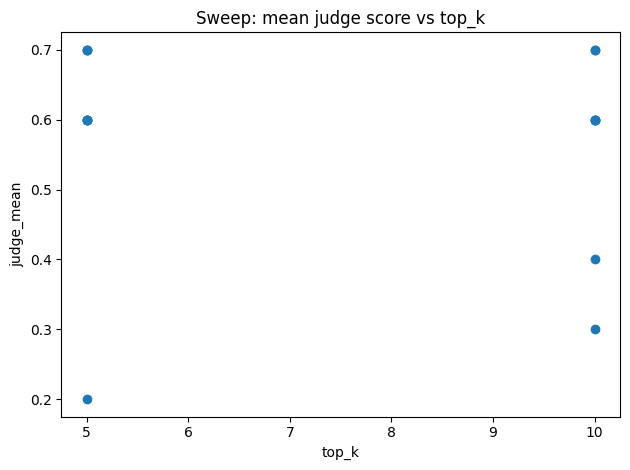

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(leaderboard["params.top_k"].astype(float),
            leaderboard["metrics.judge_mean"].astype(float))
plt.xlabel("top_k")
plt.ylabel("judge_mean")
plt.title("Sweep: mean judge score vs top_k")
plt.tight_layout()
plt.show()


In [31]:
with mlflow.start_run(run_name="sweep_summary"):
    mlflow.log_artifact("sweep_leaderboard.csv")
    plt.savefig("sweep_plot.png", dpi=200, bbox_inches="tight")
    mlflow.log_artifact("sweep_plot.png")


<Figure size 640x480 with 0 Axes>